### ISC among twins and control analyses

The goal of this notebook is to measure ISC among twins and compare it against control-twins (i.e. age- and sex-matched controls) non-twins.

The hypothesis is that ISC for twin-pairs will be generally higher than for non-twin pairs (or controls). We will further concretize the control-analyses below and in the follow-up notebooks.

#### Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import sys, os, nilearn, pickle, glob, shutil, itertools, random, tqdm
from nilearn import plotting, input_data, datasets
import numpy as np
import pandas as pd
from statsmodels.stats.multitest import multipletests
from utils import *
import warnings
from tqdm import tqdm
warnings.simplefilter("ignore")
from nilearn.masking import compute_brain_mask, apply_mask
from nilearn import image
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, threshold, fdr

/Users/schmaelz/miniconda3/envs/partlycloudy2env/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


#### Setup variables and filenames

In [2]:
#if you want to read in precomputed results and skip the lengthy computation, 
# then uncomment this and skip the next cells
#result_df = pd.read_csv('../data/05_results/twin_isc_df.csv')
#result_df.head()
n_regions        = 293
fmri_data_file   = '../data/03_extract_ts_aus/ts_array_shen268_pauli16_aan9.npy'
all293_rois_file = '../data/02_rois_masks_maps/allcombined.nii'

#### Load viewer info, set up masker, load timeseries

In [3]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')
print(twin_list[:3])

twin_df.head() #'''
print(' ')

# load timeseries, swap axes
ts_array = np.load(fmri_data_file)
ts_data  = np.swapaxes(ts_array, 0, 2)
ts_data  = np.swapaxes(ts_data, 0, 1)
print("Shape of time series structure: " + str(ts_data.shape))

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]
 
Shape of time series structure: (380, 293, 200)


#### Reading in Twin-List and computing ISC among real-twins

In [5]:
twin_df = pd.read_csv('../data/00_dataset_info/twin_df.csv')
twin_list = twin_df[['twin_A_id','twin_B_id']].values.tolist()
print(twin_list[:3])

twin_df.head() #'''
print(' ')

[['sub-0001', 'sub-0018'], ['sub-0003', 'sub-0233'], ['sub-0004', 'sub-0420']]
 


In [7]:
#'''
# Computing ISC for the real twins
n_twins       = len(twin_list)
iscs_reg_twin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    twin_iscs = []
    
    for twin_pair in twin_list:
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts_aus/' + twin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin2_data = np.load(filename_2) 
        
        twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], twin2_data[:,curr_region])[0,1])
 
    iscs_reg_twin[curr_region, :]   = twin_iscs #'''
    

#anatomical similarity
'''
anatomical_similarity_twins = []
for twin_pair in tqdm(twin_list):
        file_a = twin_pair[0]
        file_b = twin_pair[1] 

        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_twins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_twin[293,:] = np.asarray(anatomical_similarity_twins) #'''
print(' ')

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:13<00:00, 21.48it/s]

#### Reading in ControlTwin-List and computing ISC among control-twins

In [10]:
controltwin_df = pd.read_csv('../data/00_dataset_info/matched_controltwin_df.csv')
controltwin_list = controltwin_df[['twin_A_id','controltwin_B_id']].values.tolist()
print(controltwin_list[:3])

controltwin_df.head() #'''
print(' ')

[['sub-0001', 'sub-0003'], ['sub-0004', 'sub-0151'], ['sub-0005', 'sub-0043']]
 


In [11]:
#'''
# Computing ISC for the control twins
n_controltwins       = len(twin_list)
iscs_reg_controltwin = np.zeros((n_regions+1, n_controltwins))

for curr_region in tqdm(range(n_regions)):
    controltwin_iscs = []
    
    for controltwin_pair in controltwin_list:
        filename_1 = '../data/03_extract_ts_aus/' + controltwin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        controltwin1_data = np.load(filename_1) 
        filename_2 = '../data/03_extract_ts_aus/' + controltwin_pair[1] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        controltwin2_data = np.load(filename_2) 
        
        controltwin_iscs.append(np.corrcoef(controltwin1_data[:,curr_region], controltwin2_data[:,curr_region])[0,1])
 
    iscs_reg_controltwin[curr_region, :]   = controltwin_iscs #'''
    

#anatomical similarity
'''
anatomical_similarity_controltwins = []
for controltwin_pair in tqdm(controltwin_list):
        file_a = controltwin_pair[0]
        file_b = controltwin_pair[1] 

        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_controltwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_controltwin[293,:] = np.asarray(anatomical_similarity_controltwins) #'''
print(' ')

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:13<00:00, 21.56it/s]

#### Computing ISC among random people

In [13]:
#'''
iscs_reg_notwin = np.zeros((n_regions+1, n_twins))

for curr_region in tqdm(range(n_regions)):
    no_twin_iscs      = []

    for twin_pair in twin_list:
        filename_1 = '../data/03_extract_ts_aus/' + twin_pair[0] + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        twin1_data = np.load(filename_1) 

        #from the remaining people, randomly chose one, excluding the actual twin
        other_twin_list = twin_df['twin_B_id'].values.tolist()
        other_people = [x for x in other_twin_list if x != twin_pair[1]]  
        no_twin_filename_1 = '../data/03_extract_ts_aus/' + random.choice(other_people) + '_LTR_Z_THP001_LP012_shen268_pauli16_aan9.npy'
        no_twin_data1 = np.load(no_twin_filename_1) 

        no_twin_iscs.append(np.corrcoef(twin1_data[:,curr_region], no_twin_data1[:,curr_region])[0,1])

    iscs_reg_notwin[curr_region, :] = no_twin_iscs #'''
    
    
#anatomical similarity
'''
anatomical_similarity_notwins = []
for notwin_pair in tqdm(twin_list):
        file_a = notwin_pair[0]
        file_b = notwin_pair[1] 

        f1  = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f1m = '../data/04_anatomy/' + file_a + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f1_masked = apply_mask(f1, compute_brain_mask(f1m, threshold=0.01, mask_type='whole-brain'))

        f2  = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
        f2m = '../data/04_anatomy/' + file_b + '_ses-02_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
        f2_masked = apply_mask(f2, compute_brain_mask(f2m, threshold=0.01, mask_type='whole-brain'))

        anatomical_similarity_notwins.append(np.corrcoef(f1_masked, f2_masked)[0,1])

iscs_reg_notwin[293,:] = np.asarray(anatomical_similarity_notwins) #'''
print(' ')

100%|███████████████████████████████████████████████████████████████████████████████████| 293/293 [00:13<00:00, 21.29it/s]

In [23]:
# saving all that has been computed until here for future loading (bcz it takes about 50 min to re-run) 
#np.savez('../data/05_results/h2_twins_controltwins_randomothers.npz', 
#         iscs_reg_twin        = iscs_reg_twin, 
#         iscs_reg_controltwin = iscs_reg_controltwin,
#         iscs_reg_notwin      = iscs_reg_notwin,)

# can later load again via
# data = np.load('../data/05_results/h2_twins_controltwins_randomothers.npz')
# print data['iscs_reg_controltwin']
# print data['iscs_reg_twin']
# ...


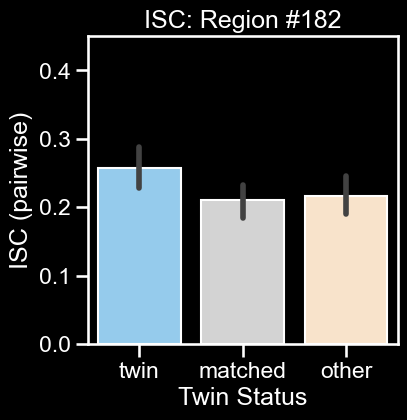

In [25]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")

current_region_index = 182
#293 is anatomical_similarity


df0 = pd.DataFrame(np.vstack(( iscs_reg_notwin[current_region_index,:], 
                   len(iscs_reg_notwin[current_region_index,:]) * ['other'] )).T, 
                  columns = ['ISC','Twin Status'])

df1 = pd.DataFrame(np.vstack(( iscs_reg_controltwin[current_region_index,:], 
                   len(iscs_reg_controltwin[current_region_index,:]) * ['matched'] )).T, 
                   columns = ['ISC','Twin Status'])

df2 = pd.DataFrame(np.vstack(( iscs_reg_twin[current_region_index,:], 
                   len(iscs_reg_twin[current_region_index,:]) * ['twin'] )).T, 
                   columns = ['ISC','Twin Status'])

result_df = pd.concat([df2, df1, df0])
del df1, df2, df0


result_df['ISC'] = result_df['ISC'].astype('float')

#result_df = pd.read_csv('../data/05_results/twin_isc_df.csv')


plt.figure(figsize =  (4,4))
sns.barplot(data=result_df, 
            x="Twin Status", 
            y="ISC",
            palette = [ 'lightskyblue','lightgrey','bisque']).set(title='ISC: Region #' + str(current_region_index));
plt.ylim([0., 0.45])
plt.ylabel('ISC (pairwise)');

In [13]:
#result_df.to_csv('../data/05_results/twin_isc_df.csv')

In [27]:
iscs_reg_twin.shape

(294, 100)

<Axes: >

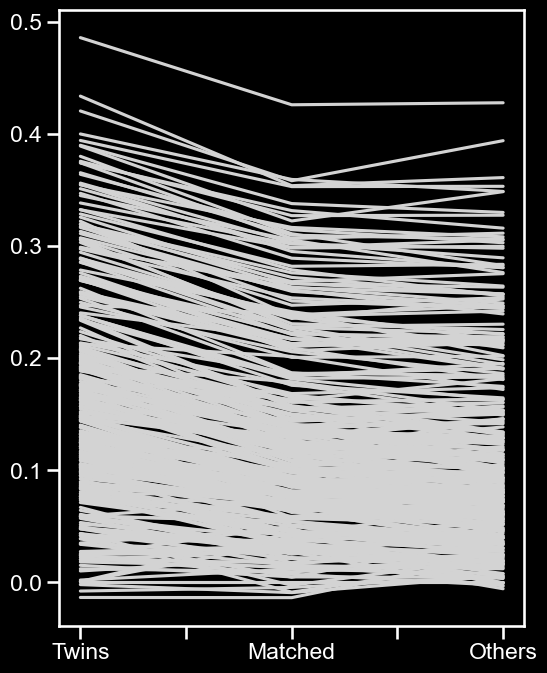

In [55]:
iscs_reg_twin.mean(axis = 1)
df = pd.DataFrame({'Twins': iscs_reg_twin.mean(axis = 1), 
                   'Matched': iscs_reg_controltwin.mean(axis = 1),
                   'Others': iscs_reg_notwin.mean(axis = 1)})
df.sort_values(by='Twins').T.plot(legend = False, color = 'lightgray', figsize = (6,8))